# Surrogate model

## Imports

In [1]:

from datetime import datetime

import matplotlib.pyplot as plt
import shap
import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from mlps import *

## Seed

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load dataset

In [3]:
dataset_type = 'res'  # 'res' or 'phavg'
case = 'full'
case_array_dir = dataset_directory / case / 'array' / dataset_type
max_samples = int(1e9)
slice = 0

In [4]:
X = np.load(case_array_dir / 'X.npy')[max_samples * slice: max_samples * (slice + 1)]
Y = np.load(case_array_dir / 'Y.npy')[max_samples * slice: max_samples * (slice + 1)]
json_norm_infos = json.load(open(case_array_dir / 'norm.json'))

In [5]:
X_mean, X_std = json_norm_infos['X mean'], json_norm_infos['X std']
Y_mean, Y_std = json_norm_infos['Y mean'], json_norm_infos['Y std']

In [6]:
X.shape, Y.shape

((262136, 7), (262136, 2))

## Split dataset

In [7]:
# split test and train
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    shuffle=True,
                                                    test_size=surrogate_model_test_split)

In [8]:
# move data to device
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
Y_train = torch.from_numpy(Y_train).float().to(device)
Y_test = torch.from_numpy(Y_test).float().to(device)

In [9]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([235922, 7]),
 torch.Size([26214, 7]),
 torch.Size([235922, 2]),
 torch.Size([26214, 2]))

## Define model
Try  to find out the best model (R^6^ -> R^5^)

In [10]:
model = create_mlp(widths=surrogate_model_layer_widths)
model = model.to(device)
model

Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=32, bias=True)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=64, bias=True)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=128, bias=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=256, bias=True)
  (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=256, out_features=512, bias=True)
  (16): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): ReLU()
  (18): Linear(in_f

### Training settings

In [11]:
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, Y_train),
    batch_size=surrogate_model_batch_size,
    shuffle=True
)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=surrogate_model_learning_rate,
                             weight_decay=surrogate_model_regularizer)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=surrogate_model_scheduler_step_size,
                                            gamma=surrogate_model_scheduler_gamma)
loss_fn = nn.MSELoss()
print_every = 100

### Tuning

In [12]:
tuned_model = None # 'surrogate_model_phavg-full-2023.12.08_22.09.42.zip'
if tuned_model is not None:
    model = load_model(tuned_model)
    raise Exception('Stop here!')

## Train model

In [13]:
train_losses = []
mean_loss = 0
_trange = tqdm.trange(surrogate_model_epochs, unit='epoch')
current_patience = 0
for epoch in _trange:
    epoch_sum_loss = 0
    for i, (x, y) in enumerate(data_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        epoch_sum_loss += loss.item()
        optimizer.step()
    mean_loss = epoch_sum_loss / len(data_loader)

    # Update progress bar and collect metrics
    _trange.set_description(f' Lr {scheduler.get_last_lr()[0]:.2e} -'
                            f' Mean train loss {mean_loss:.2e}')
    train_losses.append(mean_loss)
    scheduler.step()

 Lr 6.23e-06 - Mean train loss 5.16e-03: 100%|██████████| 1000/1000 [55:46<00:00,  3.35s/epoch]


In [14]:
try:
    model.eval()
    train_loss = loss_fn(model(X_train), Y_train)
    test_loss = loss_fn(model(X_test), Y_test)
    print(f'Train loss: {train_loss.item()}')
    print(f'Test loss: {test_loss.item()}')
except Exception as e:
    print(e)

Train loss: 0.004205535631626844
Test loss: 0.004985060542821884


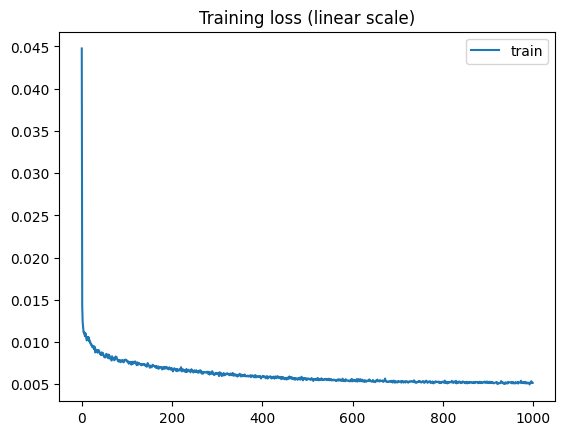

In [15]:
try:
    plt.plot(train_losses, label='train')
    plt.title('Training loss (linear scale)')
    plt.legend()
    plt.show()
except NameError:
    pass

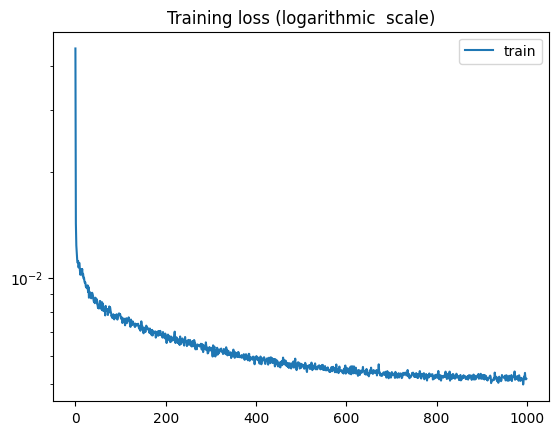

In [16]:
try:
    plt.yscale('log')
    plt.plot(train_losses, label='train')
    plt.title('Training loss (logarithmic  scale)')
    plt.legend()
    plt.show()
except NameError:
    pass

## Save model

In [17]:
timestamp_str = datetime.now().strftime("%Y.%m.%d_%H.%M.%S")
model_name = f'surrogate_model_{dataset_type}-{case}-{timestamp_str}'
save_model(model, model_name, infos={
    'model_name': model_name,
    'max_samples': max_samples,
    'dataset_type': dataset_type,
    'case': case,
    'timestamp': timestamp_str,
    'num_epochs': surrogate_model_epochs,
    'optimizer': str(optimizer),
    'scheduler': str(scheduler),
    'loss_fn': str(loss_fn),
    'train_losses': train_losses,
    'X_mean': X_mean,
    'X_std': X_std,
    'Y_mean': Y_mean,
    'Y_std': Y_std,
    'x_columns': x_columns,
    'y_columns': y_columns,
    'full_model': str(model),
    'model_layer_widths': surrogate_model_layer_widths,
    'tuned_model': tuned_model
})

## Visualization of the model

In [18]:
model, X_train, X_test, Y_train, Y_test = model.cpu(), X_train.cpu(), X_test.cpu(), Y_train.cpu(), Y_test.cpu()

In [19]:
n_features = Y_train.shape[1]
n_points = 1000
sub_X_train = X_train[:n_points]
sub_X_test = X_test[:n_points]
sub_Y_train = Y_train[:n_points]
sub_Y_test = Y_test[:n_points]
Y_train_pred = model(sub_X_train).detach().numpy()
Y_test_pred = model(sub_X_test).detach().numpy()

### PCA on X

In [20]:
pca2d = PCA(n_components=2)
X_train_2d = pca2d.fit_transform(X_train)
X_test_2d = pca2d.transform(X_test)
sub_X_train_2d = X_train_2d[:n_points]
sub_X_test_2d = X_test_2d[:n_points]

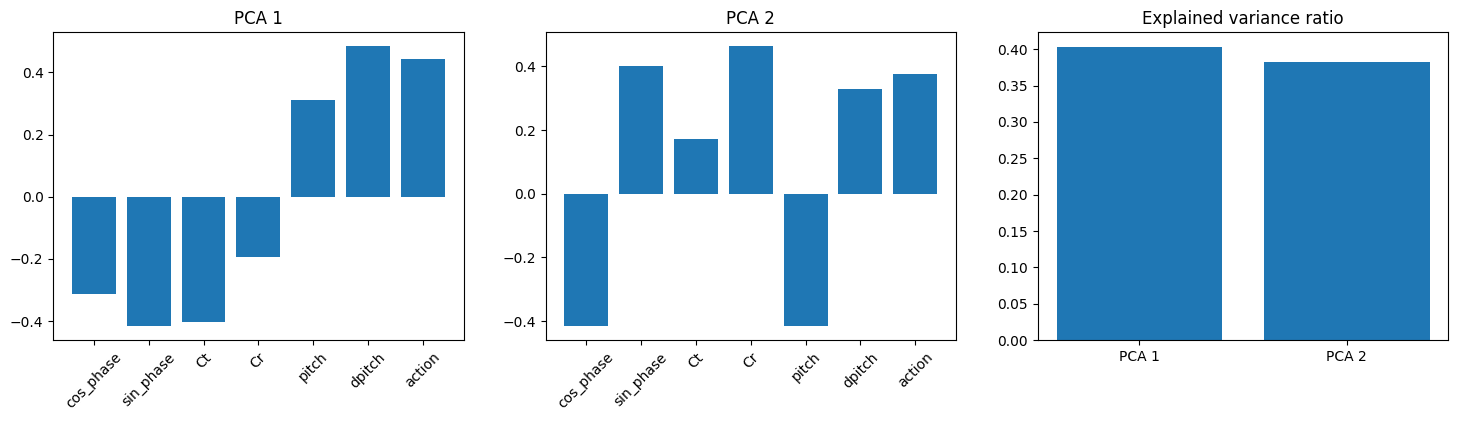

In [21]:
# plot the pca principal and second principal vector as a bar plot. Plot the explained variance ratio as a bar plot.
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].bar(np.arange(len(x_columns)), pca2d.components_[0])
axes[0].set_title('PCA 1')
axes[1].bar(np.arange(len(x_columns)), pca2d.components_[1])
axes[1].set_title('PCA 2')
axes[2].bar(np.arange(2), pca2d.explained_variance_ratio_)
axes[2].set_title('Explained variance ratio')
axes[0].set_xticks(np.arange(len(x_columns)))
axes[0].set_xticklabels(x_columns, rotation=45)
axes[1].set_xticks(np.arange(len(x_columns)))
axes[1].set_xticklabels(x_columns, rotation=45)
axes[2].set_xticks(np.arange(2))
axes[2].set_xticklabels(['PCA 1', 'PCA 2'])
plt.show()

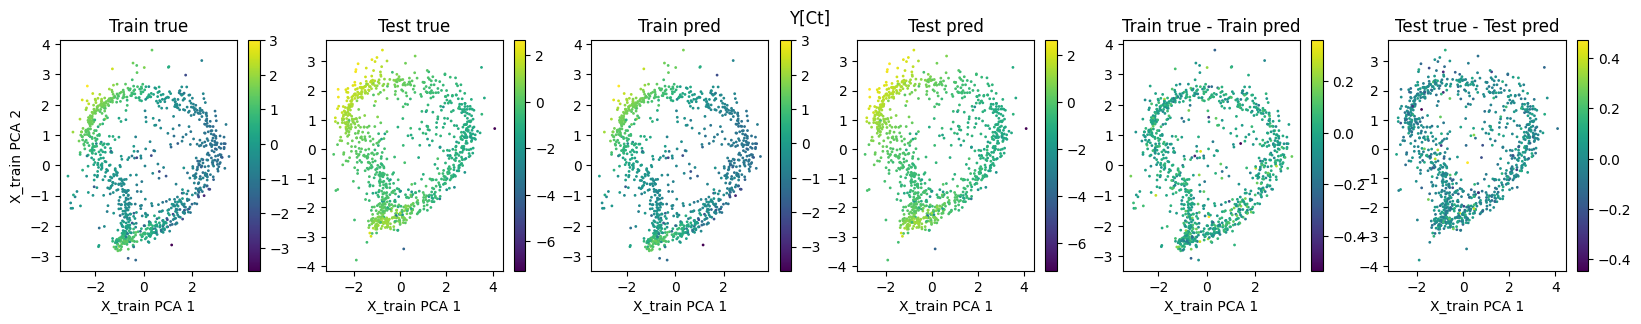

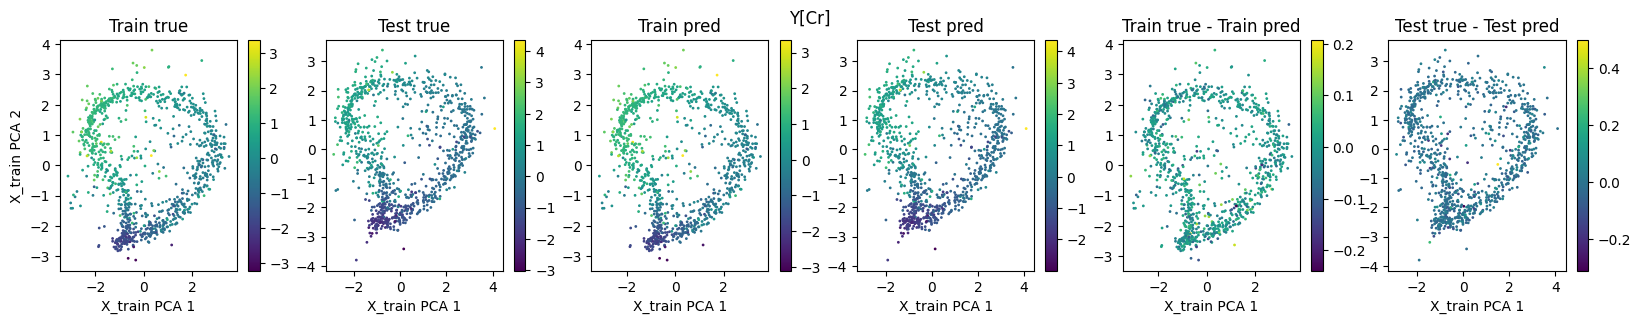

In [22]:
points_size = 1
for i in range(n_features):
    fig, axes = plt.subplots(1, 6, figsize=(20, 3))
    fig.suptitle(f'Y[{y_columns[i]}]')
    axes[0].set_title(f'Train true')
    axes[0].scatter(sub_X_train_2d[:, 0], sub_X_train_2d[:, 1], c=sub_Y_train[:, i], s=points_size)
    axes[1].set_title(f'Test true')
    axes[1].scatter(sub_X_test_2d[:, 0], sub_X_test_2d[:, 1], c=sub_Y_test[:, i], s=points_size)
    axes[2].set_title(f'Train pred')
    axes[2].scatter(sub_X_train_2d[:, 0], sub_X_train_2d[:, 1], c=Y_train_pred[:, i], s=points_size)
    axes[3].set_title(f'Test pred')
    axes[3].scatter(sub_X_test_2d[:, 0], sub_X_test_2d[:, 1], c=Y_test_pred[:, i], s=points_size)
    axes[4].set_title(f'Train true - Train pred')
    axes[4].scatter(sub_X_train_2d[:, 0], sub_X_train_2d[:, 1], c=sub_Y_train[:, i] - Y_train_pred[:, i], s=points_size)
    axes[5].set_title(f'Test true - Test pred')
    axes[5].scatter(sub_X_test_2d[:, 0], sub_X_test_2d[:, 1], c=sub_Y_test[:, i] - Y_test_pred[:, i], s=points_size)
    axes[0].set_xlabel('X_train PCA 1')
    axes[0].set_ylabel('X_train PCA 2')
    axes[1].set_xlabel('X_train PCA 1')
    axes[2].set_xlabel('X_train PCA 1')
    axes[3].set_xlabel('X_train PCA 1')
    axes[4].set_xlabel('X_train PCA 1')
    axes[5].set_xlabel('X_train PCA 1')
    fig.colorbar(axes[0].collections[0], ax=axes[0])
    fig.colorbar(axes[1].collections[0], ax=axes[1])
    fig.colorbar(axes[2].collections[0], ax=axes[2])
    fig.colorbar(axes[3].collections[0], ax=axes[3])
    fig.colorbar(axes[4].collections[0], ax=axes[4])
    fig.colorbar(axes[5].collections[0], ax=axes[5])

    plt.show()

## Explain impact of features on the model using SHAP

In [23]:
n = 100

# Assuming X_test contains your input features
numpy_model = lambda x: model(torch.from_numpy(x).float()).detach().numpy()
X_test_np = X_test[:n].numpy()
Y_test_np = Y_test[:n].numpy()

# Set the model to evaluation mode
model.eval()

# Create a SHAP explainer
explainer = shap.KernelExplainer(numpy_model, X_test_np)

shap_values = explainer.shap_values(X_test_np)

  0%|          | 0/100 [00:00<?, ?it/s]

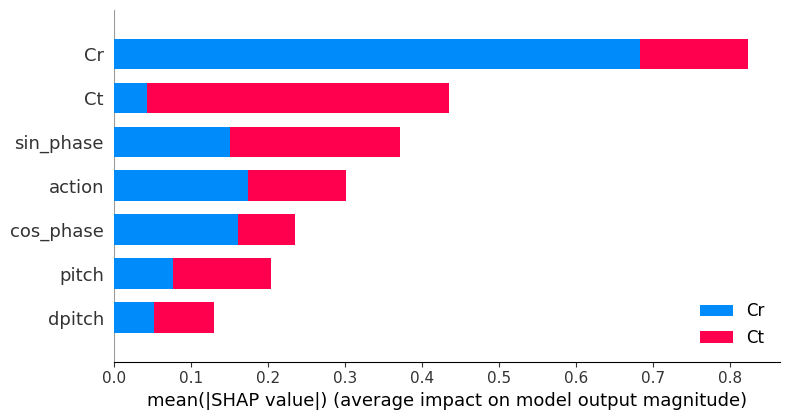

In [24]:
# Plot summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_np, feature_names=np.array(x_columns), show=False,
                  class_names=np.array(y_columns))
plt.show()

## Explain true impact of features on labels using correlation

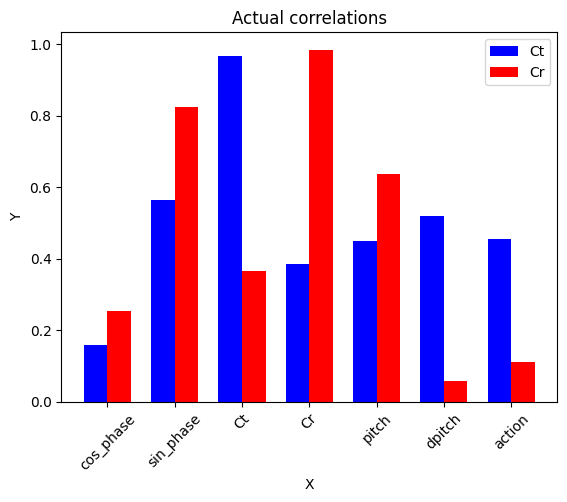

In [25]:
combined_data = np.concatenate((X_test_np, Y_test_np), axis=1)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(combined_data, rowvar=False)

# correlation inputs outputs
correlation_inputs_outputs = abs(correlation_matrix[len(x_columns):, :len(x_columns)])

# Indices for each group of bars
indices = np.arange(len(x_columns))

# Create a figure and axis
bar_width = 0.35

fig, ax = plt.subplots()

# Plot bars for the first set (blue bars)
bar1 = ax.bar(indices, correlation_inputs_outputs[0, :], bar_width, color='blue', label=y_columns[0])

# Plot bars for the second set (red bars)
bar2 = ax.bar(indices + bar_width, correlation_inputs_outputs[1, :], bar_width, color='red', label=y_columns[1])

# Set labels, title, and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Actual correlations')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(x_columns, rotation=45)
ax.legend()

# Show the plot
plt.show()

## Test impact of action on predictions

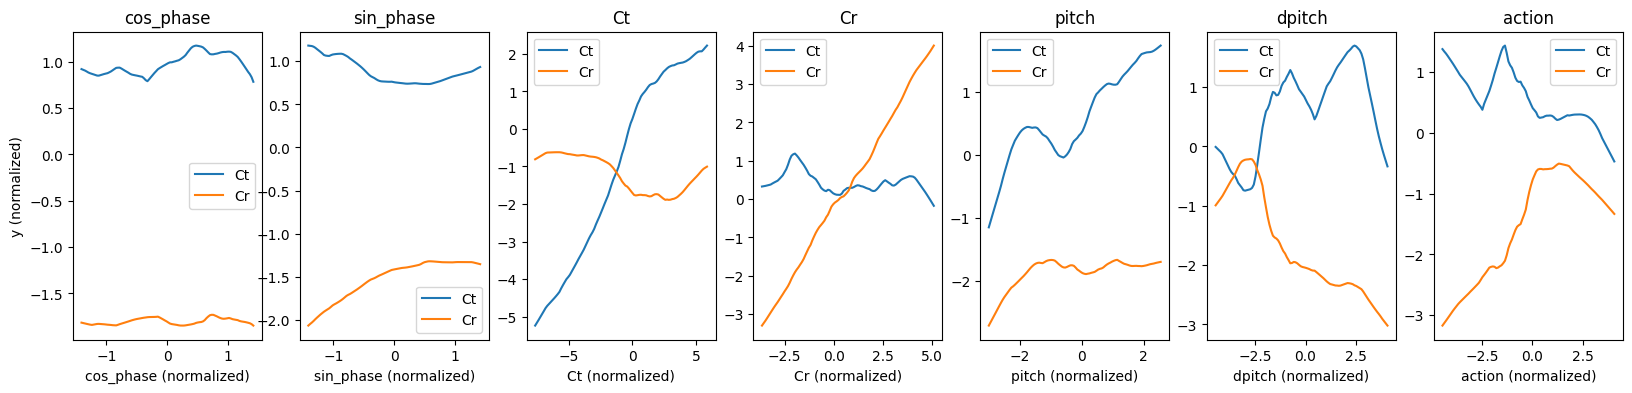

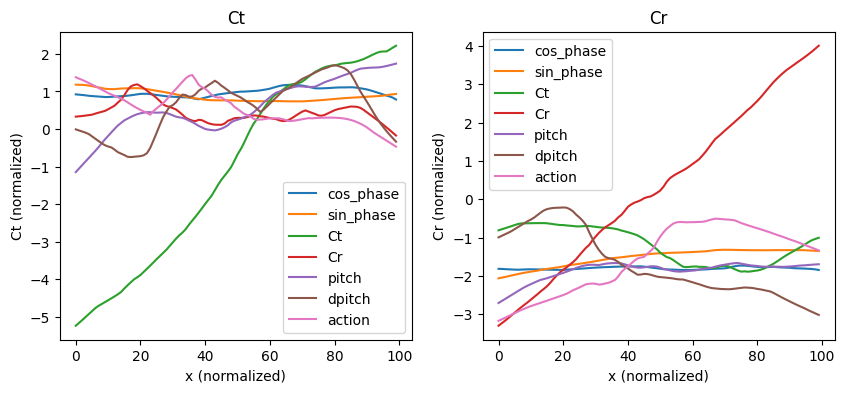

In [26]:
original_state = X[0]
cts, crs = [], []
fig, axes = plt.subplots(1, len(x_columns), figsize=(20, 4))
for i, col in enumerate(x_columns):
    min_feature = min(X[:, x_columns.index(col)])
    max_feature = max(X[:, x_columns.index(col)])

    test_feature = np.linspace(min_feature, max_feature, 100)

    x = original_state.copy()
    x = torch.from_numpy(x).float()  #.to(device)
    x = x.unsqueeze(0)
    x = x.repeat(len(test_feature), 1)
    x[:, x_columns.index(col)] = torch.from_numpy(test_feature).float()  #.to(device)
    y = model(x).detach().numpy()

    cts.append(y[:, y_columns.index('Ct')])
    crs.append(y[:, y_columns.index('Cr')])

    axes[i].plot(test_feature, y, label=y_columns)
    axes[i].legend()
    axes[i].set_xlabel(f'{col} (normalized)')
    if i == 0:
        axes[i].set_ylabel('y (normalized)')
    axes[i].set_title(col)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ct, col in zip(cts, x_columns):
    axes[0].plot(ct, label=col)
axes[0].set_ylabel('Ct (normalized)')
axes[0].set_xlabel('x (normalized)')
axes[0].legend()
axes[0].set_title('Ct')
for cr, col in zip(crs, x_columns):
    axes[1].plot(cr, label=col)
axes[1].set_ylabel('Cr (normalized)')
axes[1].set_xlabel('x (normalized)')
axes[1].legend()
axes[1].set_title('Cr')
plt.show()

### Features of X vs Y

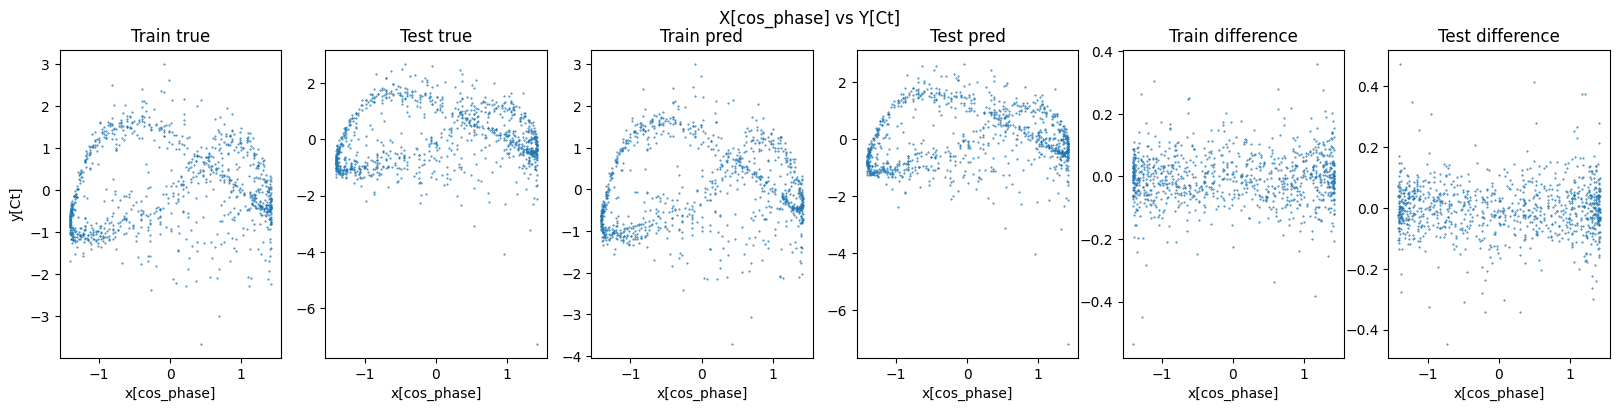

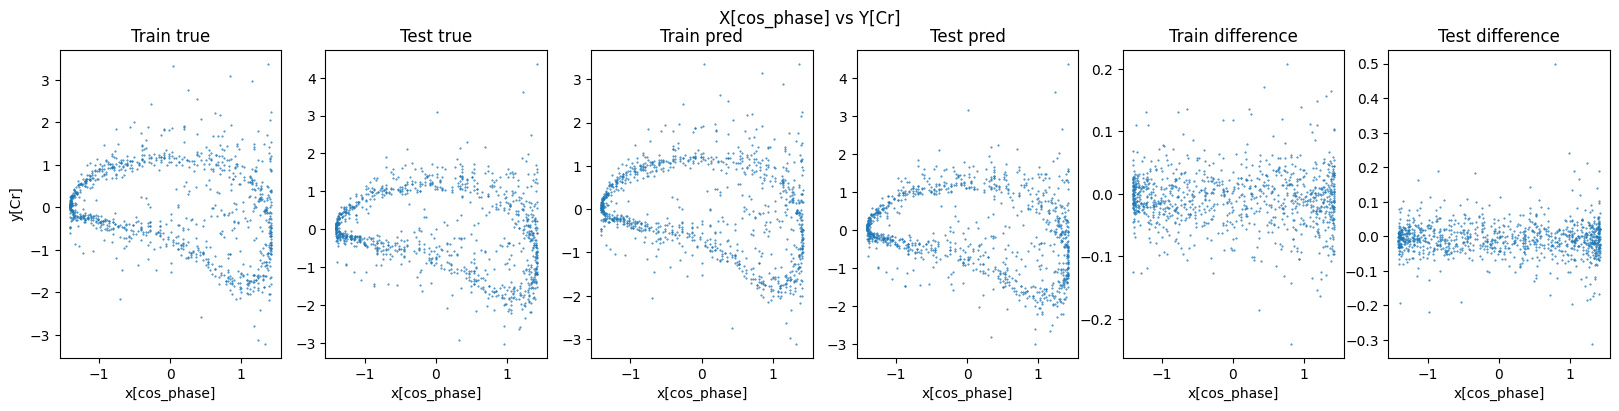

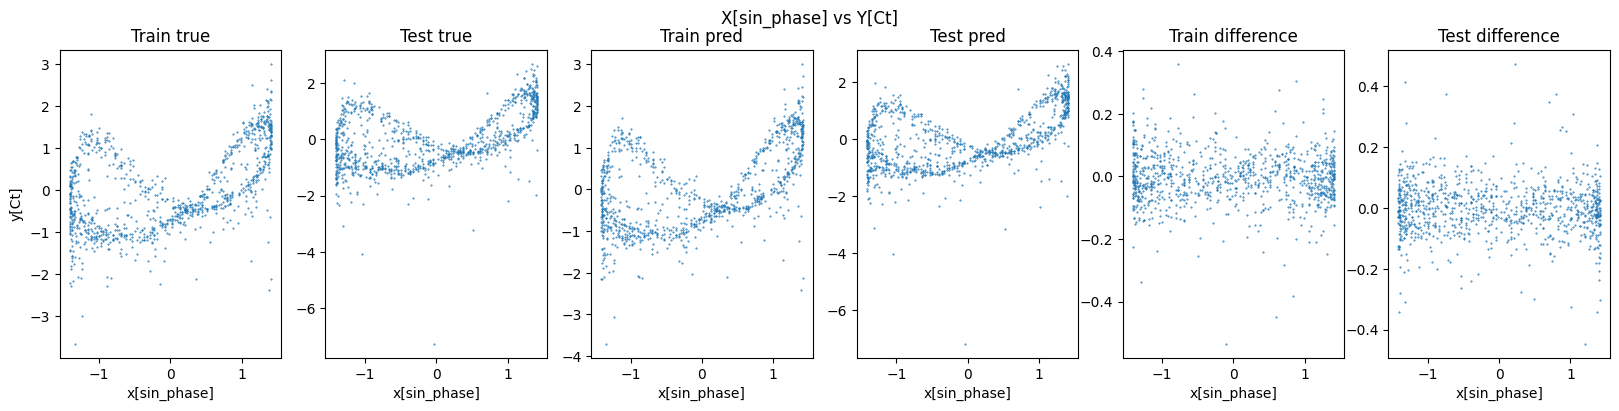

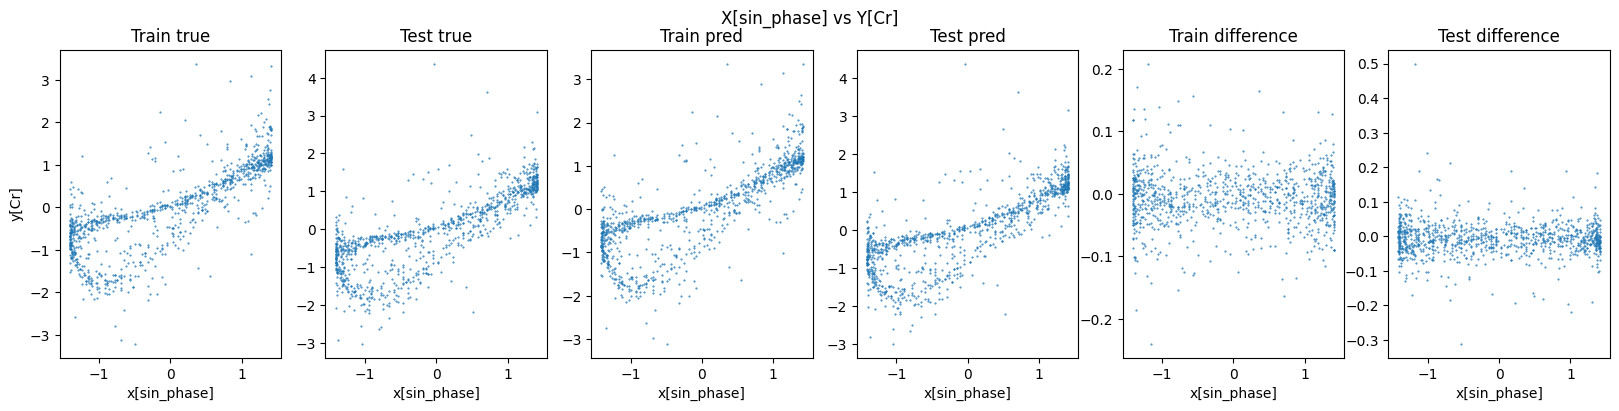

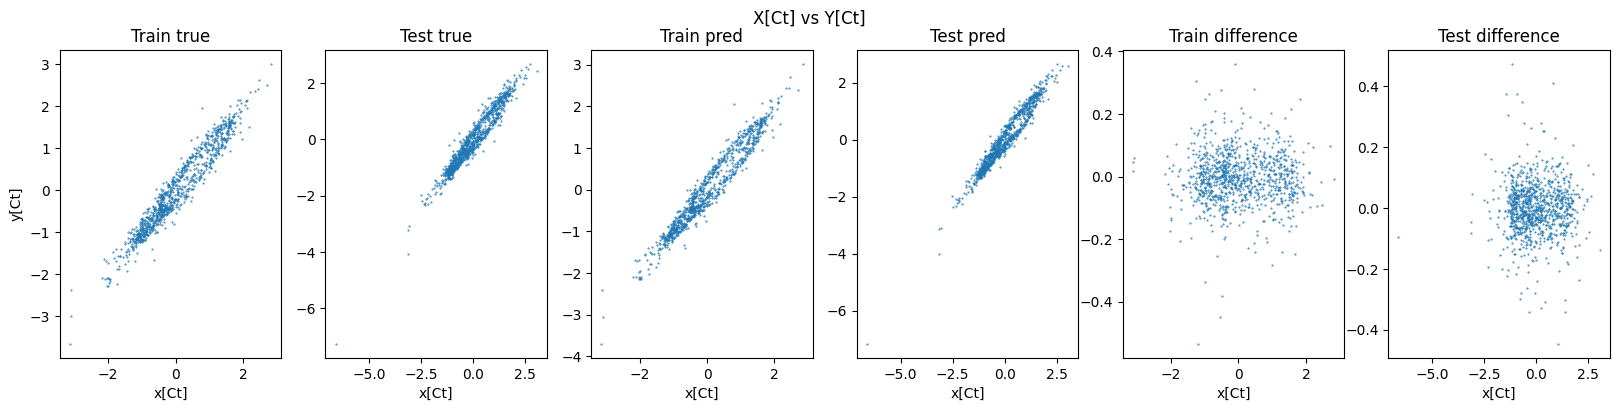

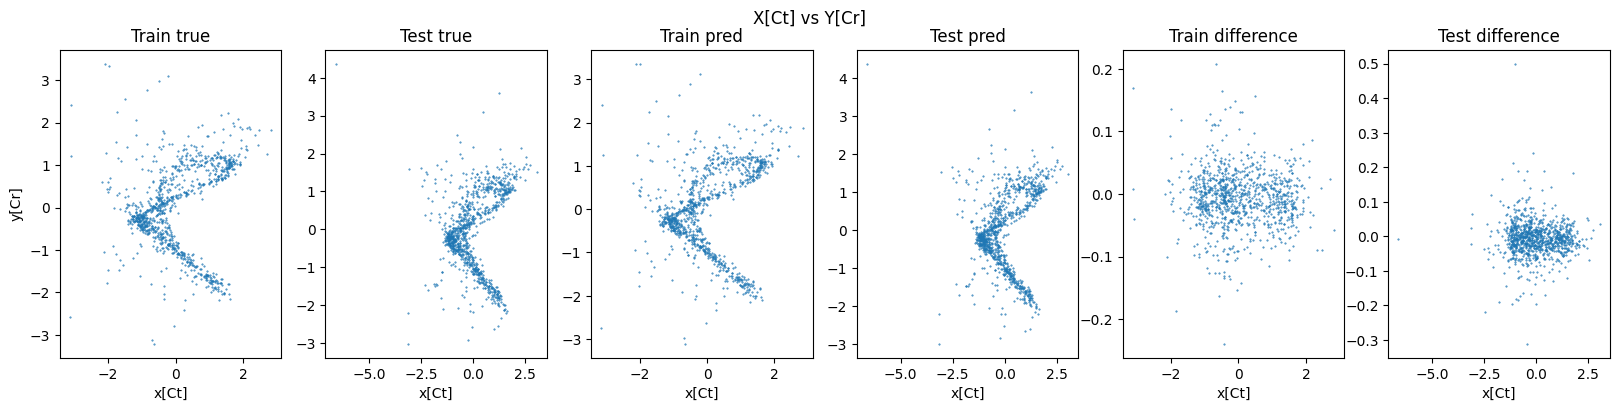

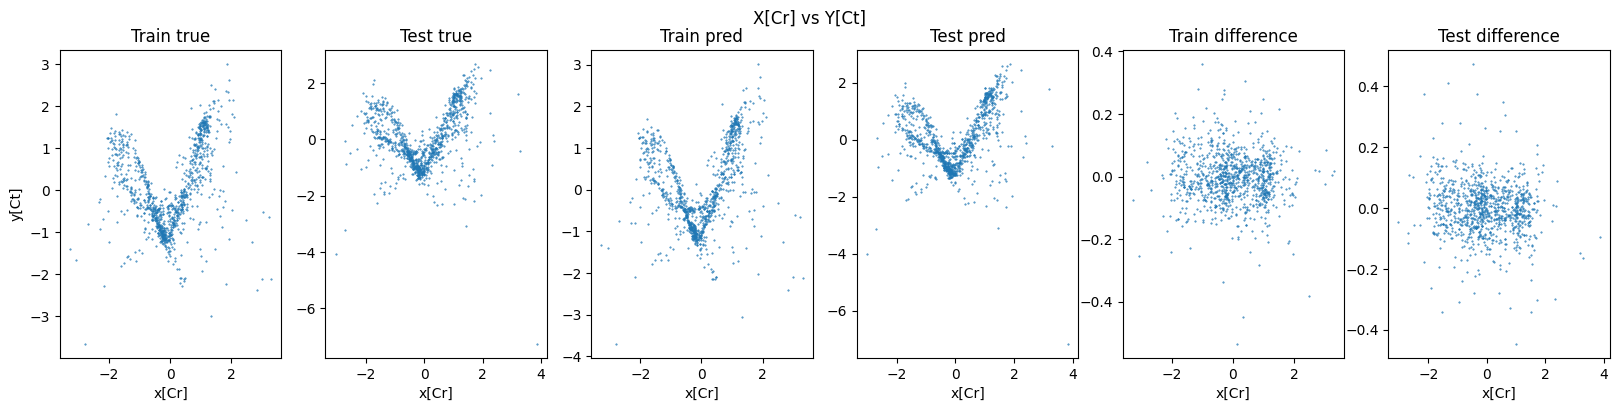

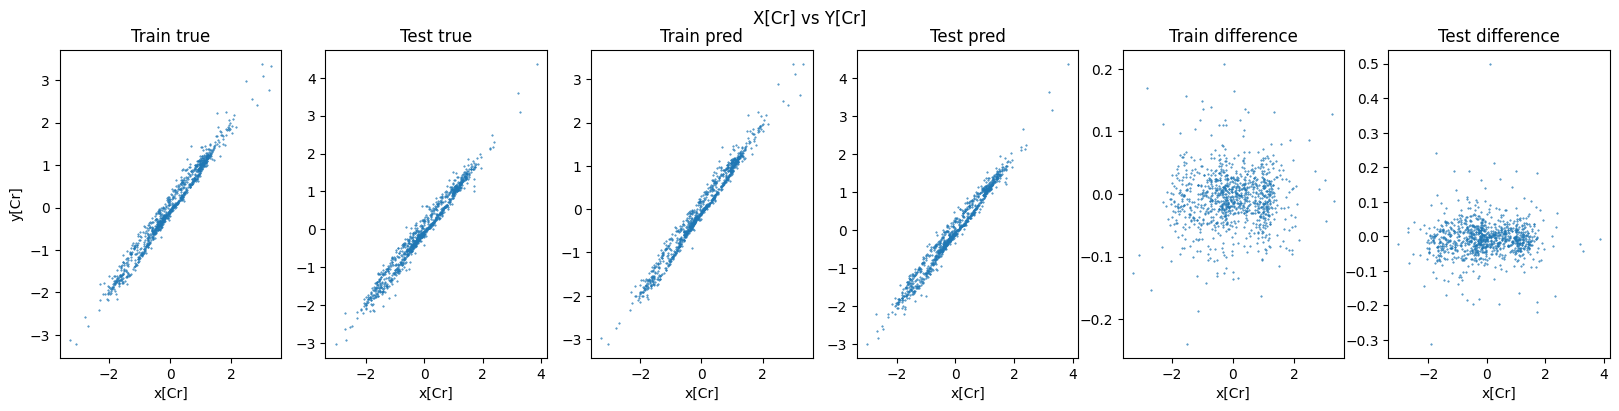

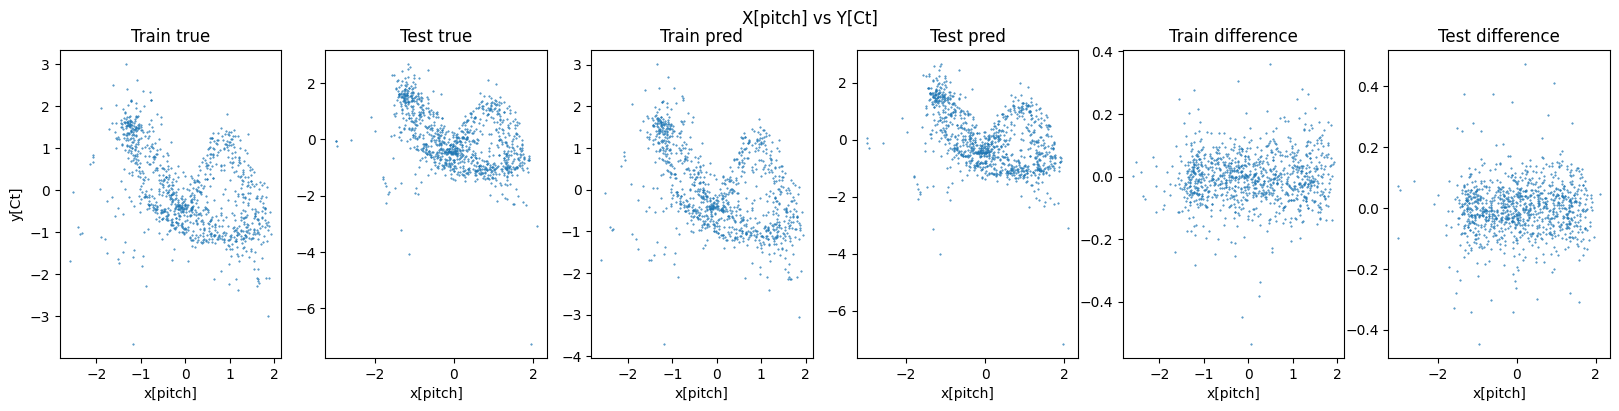

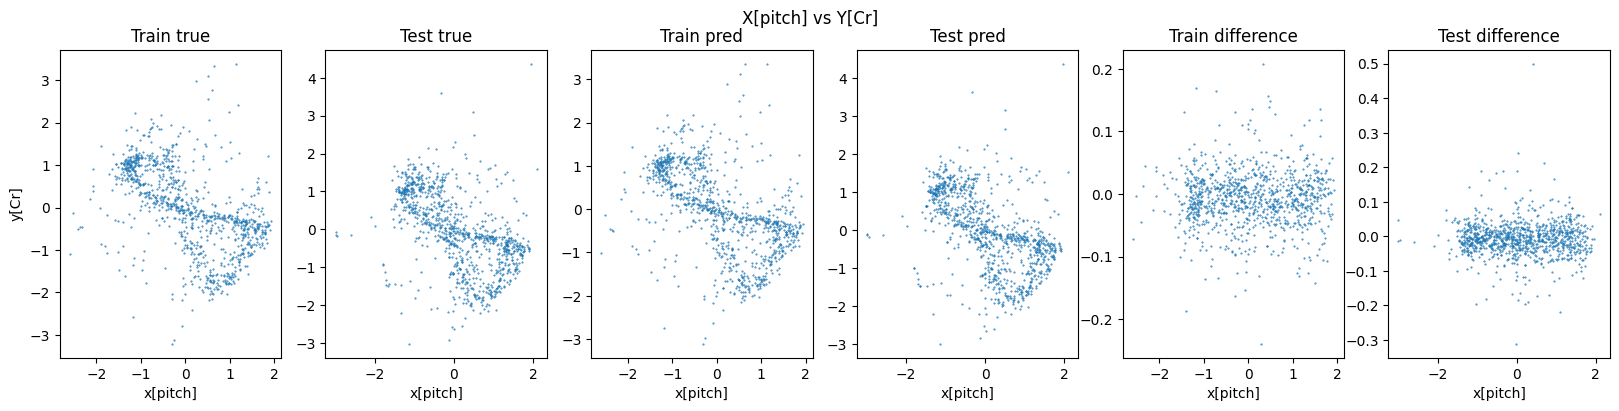

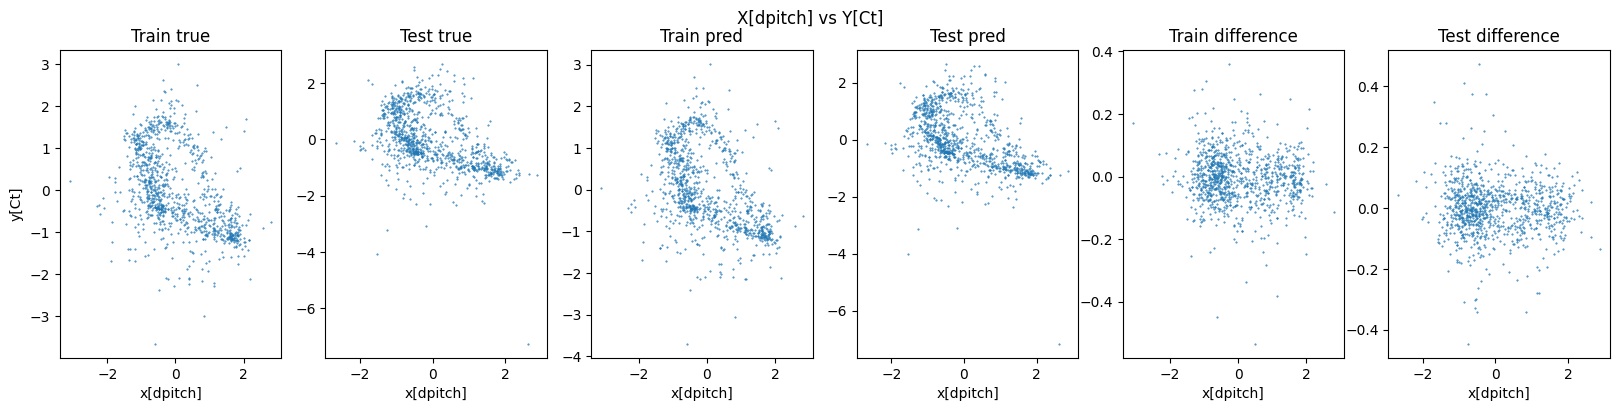

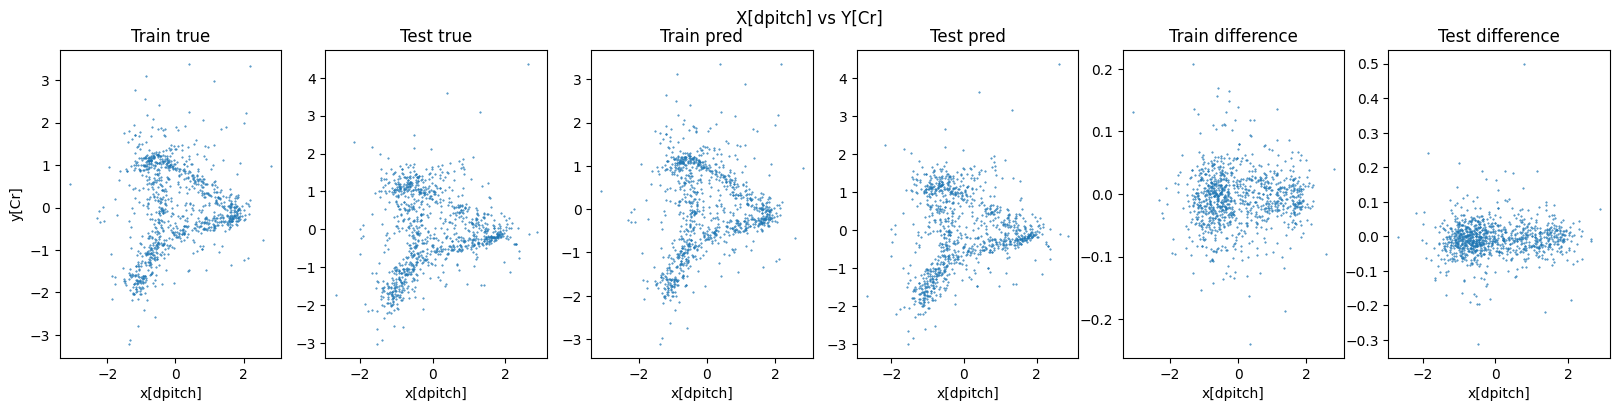

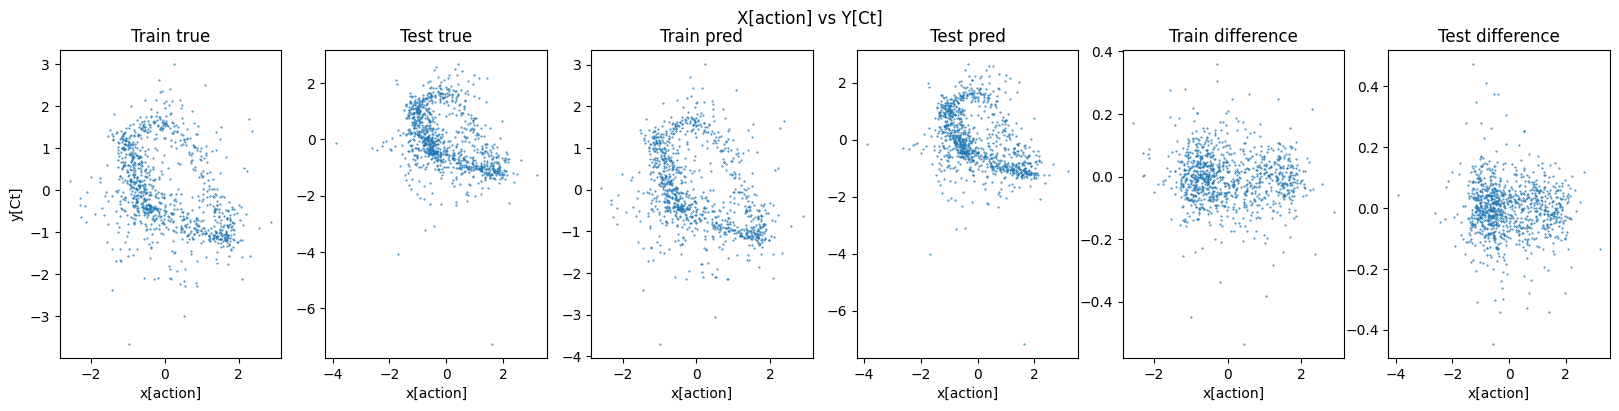

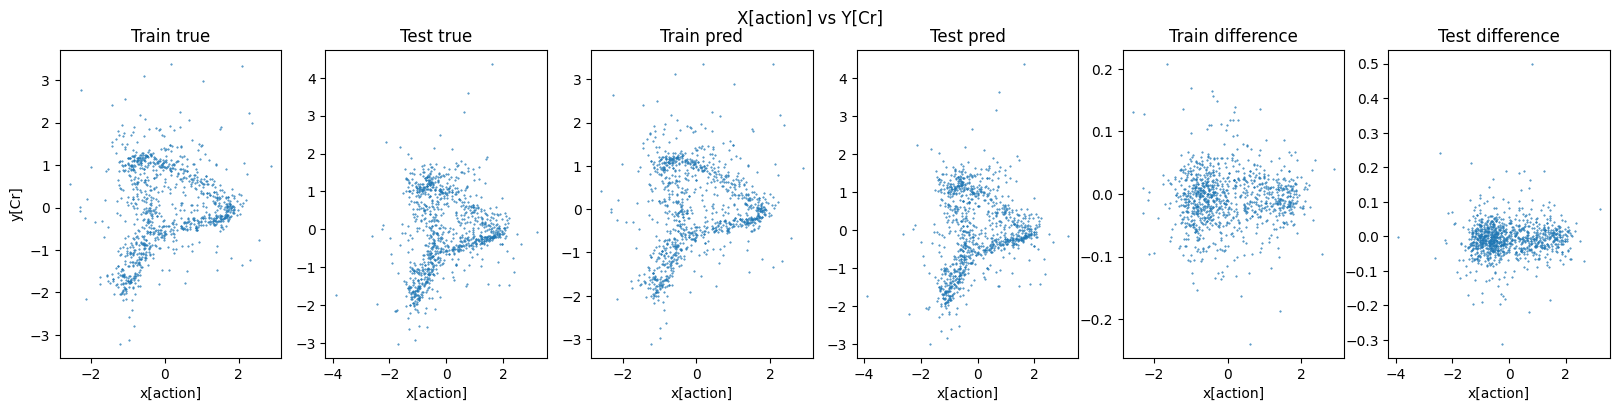

In [27]:
points_size = .2
for j in range(X.shape[1]):
    for i in range(Y.shape[1]):
        fig, axes = plt.subplots(1, 6, figsize=(20, 4))
        fig.suptitle(f'X[{x_columns[j]}] vs Y[{y_columns[i]}]')
        axes[0].set_title(f'Train true')
        axes[0].scatter(sub_X_train[:, j], sub_Y_train[:, i], s=points_size)
        axes[1].set_title(f'Test true')
        axes[1].scatter(sub_X_test[:, j], sub_Y_test[:, i], s=points_size)
        axes[2].set_title(f'Train pred')
        axes[2].scatter(sub_X_train[:, j], Y_train_pred[:, i], s=points_size)
        axes[3].set_title(f'Test pred')
        axes[3].scatter(sub_X_test[:, j], Y_test_pred[:, i], s=points_size)
        axes[4].set_title(f'Train difference')
        axes[4].scatter(sub_X_train[:, j], sub_Y_train[:, i] - Y_train_pred[:, i], s=points_size)
        axes[5].set_title(f'Test difference')
        axes[5].scatter(sub_X_test[:, j], sub_Y_test[:, i] - Y_test_pred[:, i], s=points_size)
        axes[0].set_xlabel(f'x[{x_columns[j]}]')
        axes[0].set_ylabel(f'y[{y_columns[i]}]')
        axes[0].set_ylabel(f'y[{y_columns[i]}]')
        axes[1].set_xlabel(f'x[{x_columns[j]}]')
        axes[2].set_xlabel(f'x[{x_columns[j]}]')
        axes[3].set_xlabel(f'x[{x_columns[j]}]')
        axes[4].set_xlabel(f'x[{x_columns[j]}]')
        axes[5].set_xlabel(f'x[{x_columns[j]}]')
        plt.show()